In [2]:
#@markdown ###Download a test dataset


import requests
import zipfile
import io

# Define the Zenodo link
zenodo_link = "https://zenodo.org/record/10650763/files/data66.zip?download=1"

# Download the file
response = requests.get(zenodo_link)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Specify the destination folder for extraction
destination_folder = '/content' + "//data"


# Extract the contents of the zip file to the destination folder
zip_file.extractall(destination_folder)

# Close the zip file
zip_file.close()

!rm -rf data/__MACOSX/
!rm /content/data/data66/Test\ -\ Images/.DS_Store

In [12]:
#@markdown ###Download packages
!pip install gputools > /dev/null 2>&1
!pip install stardist > /dev/null 2>&1
!pip install -q fpdf2 > /dev/null 2>&1

In [4]:
#@markdown ###Train model
import numpy as np
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available, relabel_image_stardist, random_label_cmap,  relabel_image_stardist, _draw_polygons, export_imagej_rois
from stardist.models import Config2D, StarDist2D, StarDistData2D
from csbdeep.utils import Path, normalize
from skimage import io
import pandas as pd
import os
import csv
import time

# Set up paths to your training data
train_images_path = "/content/data/data66/Training - Images" #@param{type:"string"}
train_labels_path = "/content/data/data66/Training - Masks" #@param{type:"string"}

# Load training data
X = [io.imread(image_path, as_gray=True) for image_path in sorted(Path(train_images_path).glob("*.png"))]
Y = [io.imread(label_path) for label_path in sorted(Path(train_labels_path).glob("*.png"))]

# Normalize images
X = [normalize(image, 1, 99.8, axis=(0, 1)) for image in X]

# Create a configuration for training
config = Config2D(
    n_rays=32,
    grid=(2, 2),
    use_gpu=False,
    train_patch_size=(128, 128),
    train_batch_size=4,
)

# Split data into training and validation sets
# You can adjust the validation fraction as needed
percentage = 0.2
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(percentage * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]


# Create a StarDist model with the given configuration
model = StarDist2D(config=config, name='stardist_model')

start = time.time()
# Train the model
history = model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), epochs=20)

# Save the trained model
model_path = "./model.zip"

model.optimize_thresholds(X_val, Y_val)
model.export_TF(fname=model_path)

lossData = pd.DataFrame(history.history)

os.makedirs("./stardist_model/Quality Control")

# The training evaluation.csv is saved (overwrites the Files if needed).
lossDataCSVpath = './stardist_model/Quality Control/training_evaluation.csv'
with open(lossDataCSVpath, 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['loss','val_loss', 'learning rate'])
  for i in range(len(history.history['loss'])):
    writer.writerow([history.history['loss'][i], history.history['val_loss'][i], history.history['lr'][i]])
# Displaying the time elapsed for training
dt = time.time() - start
mins, sec = divmod(dt, 60)
hour, mins = divmod(mins, 60)
print("Time elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)")

#print("Your model has been sucessfully exported and can now also be used in the Stardist Fiji plugin")

100/100 [==============================] - 2s 20ms/step - loss: 0.3098 - prob_loss: 0.0326 - dist_loss: 1.3856 - prob_kld: 0.0054 - dist_relevant_mae: 1.3854 - dist_relevant_mse: 6.0647 - dist_dist_iou_metric: 0.7414 - val_loss: 0.5151 - val_prob_loss: 0.0534 - val_dist_loss: 2.3087 - val_prob_kld: 0.0252 - val_dist_relevant_mae: 2.3085 - val_dist_relevant_mse: 14.6484 - val_dist_dist_iou_metric: 0.6050 - lr: 3.0000e-04
Epoch 20/20
100/100 [==============================] - 2s 20ms/step - loss: 0.3067 - prob_loss: 0.0329 - dist_loss: 1.3690 - prob_kld: 0.0056 - dist_relevant_mae: 1.3688 - dist_relevant_mse: 5.8258 - dist_dist_iou_metric: 0.7430 - val_loss: 0.4892 - val_prob_loss: 0.0516 - val_dist_loss: 2.1877 - val_prob_kld: 0.0234 - val_dist_relevant_mae: 2.1875 - val_dist_relevant_mse: 13.3215 - val_dist_dist_iou_metric: 0.6254 - lr: 3.0000e-04

Loading network weights from 'weights_best.h5'.


NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:00<00:00, 28.34it/s, 0.608 -> 0.700]


Using optimized values: prob_thresh=0.606018, nms_thresh=0.3.
Saving to 'thresholds.json'.


tf.py (177): 
***IMPORTANT NOTE***

You are using 'tensorflow' 2.x, hence it is likely that the exported model *will not work*
in associated ImageJ/Fiji plugins (e.g. CSBDeep and StarDist).

If you indeed have problems loading the exported model in Fiji, the current workaround is
to load the trained model in a Python environment with installed 'tensorflow' 1.x and then
export it again. If you need help with this, please read:

https://gist.github.com/uschmidt83/4b747862fe307044c722d6d1009f6183

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Time elapsed: 0.0 hour(s) 1.0 min(s) 10 sec(s)


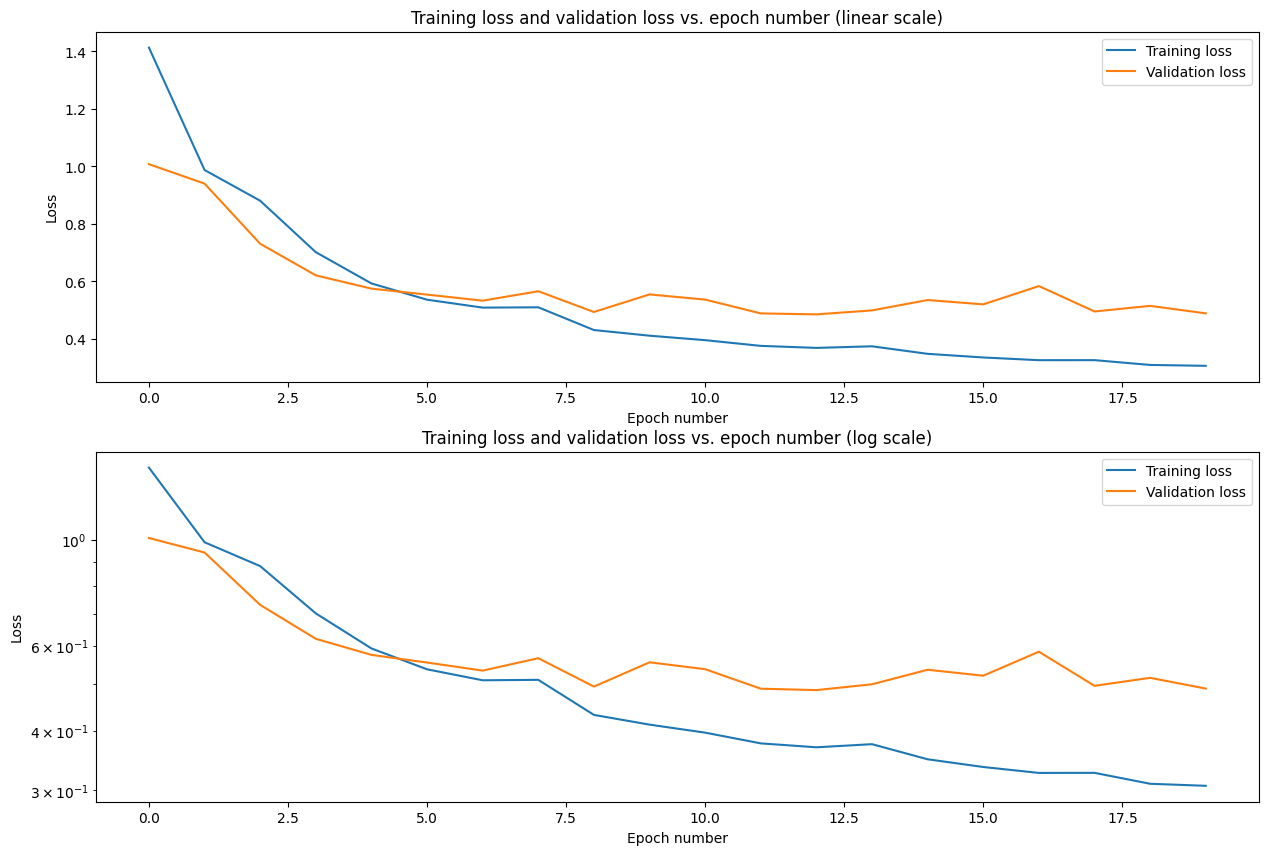

In [5]:
#@markdown ####Play the cell to show a plot of training errors vs. epoch number
from matplotlib import pyplot as plt

lossDataFromCSV = []
vallossDataFromCSV = []

with open('./stardist_model/Quality Control/training_evaluation.csv','r') as csvfile:
    csvRead = csv.reader(csvfile, delimiter=',')
    next(csvRead)
    for row in csvRead:
        lossDataFromCSV.append(float(row[0]))
        vallossDataFromCSV.append(float(row[1]))

epochNumber = range(len(lossDataFromCSV))
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(epochNumber,lossDataFromCSV, label='Training loss')
plt.plot(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (linear scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()

plt.subplot(2,1,2)
plt.semilogy(epochNumber,lossDataFromCSV, label='Training loss')
plt.semilogy(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (log scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()
plt.savefig('./stardist_model/Quality Control/lossCurvePlots.png',bbox_inches='tight',pad_inches=0)
plt.show()

Number of test dataset found in the folder: 2
Normalizing image channels independently
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.606018, nms_thresh=0.3.
frame50_7.png
Running QC on: frame50_7.png
frame50_14.png
Running QC on: frame50_14.png
+----+----------------+--------------------------------------------+------------------+-----------------+------------------+-------------+----------+------------+------------+----------+----------+-------------------+----------------------+--------------------+
|    | image          |   Prediction v. GT Intersection over Union |   false positive |   true positive |   false negative |   precision |   recall |   accuracy |   f1 score |   n_true |   n_pred |   mean_true_score |   mean_matched_score |   panoptic_quality |
|----+----------------+--------------------------------------------+------------------+-----------------+------------------+-------------+----------+-

interactive(children=(Dropdown(description='file', options=('frame50_7.png', 'frame50_14.png'), value='frame50…

__init__.py (33): Setuptools is replacing distutils.


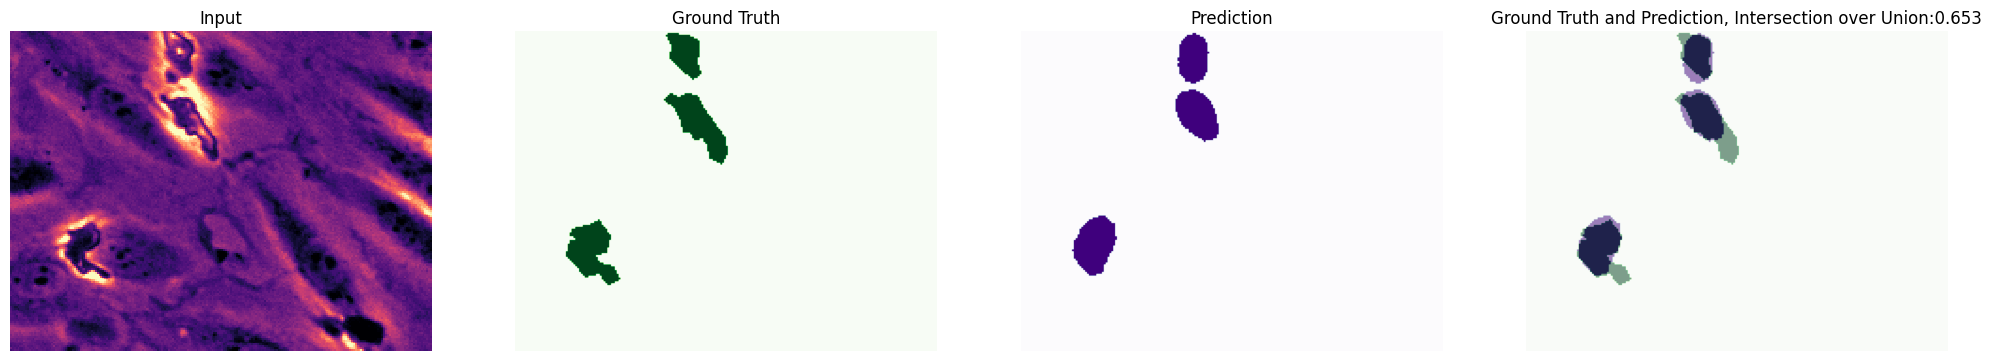

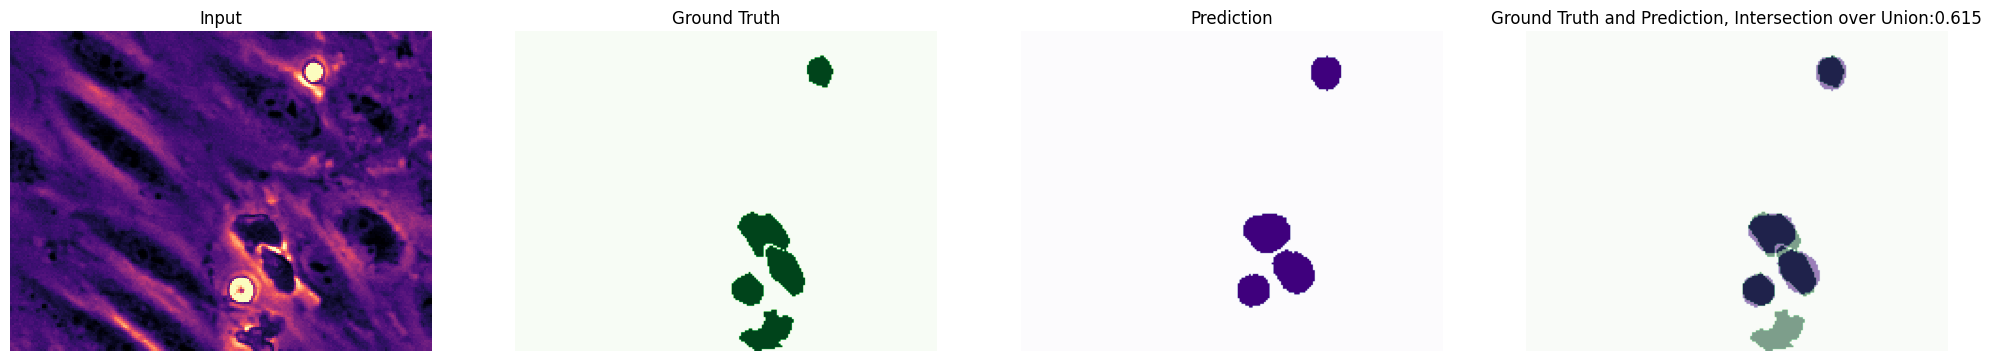

In [6]:
#@markdown ####Choose the folders that contain your Quality Control dataset
import shutil
from stardist.matching import matching
from stardist.plot import render_label, render_label_pred
from glob import glob
from tifffile import imread, imsave, imwrite
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

base_path = '/content'
QC_model_path = '/content'
QC_model_name = 'stardist_model'
full_QC_model_path = QC_model_path+'/'+QC_model_name+'/'


Source_QC_folder = "/content/data/data66/Test - Images"  #@param{type:"string"}
Target_QC_folder = "/content/data/data66/Test - Masks"  #@param{type:"string"}


#Create a quality control Folder and check if the folder already exist
if os.path.exists(QC_model_path+"/"+QC_model_name+"/Quality Control") == False:
  os.makedirs(QC_model_path+"/"+QC_model_name+"/Quality Control")

if os.path.exists(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction"):
  shutil.rmtree(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")

os.makedirs(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")

tiff = True
# Generate predictions from the Source_QC_folder and save them in the QC folder

Source_QC_folder_tif = Source_QC_folder+"/[!\\.]*"
np.random.seed(16)
lbl_cmap = random_label_cmap()
Z = sorted(glob(Source_QC_folder_tif))
if Z[0].split('.')[-1] == 'tif':
  Z = list(map(imread,Z))
  n_channel = 1 if Z[0].ndim == 2 else Z[0].shape[-1]
else:
  tiff = False
  Z = [io.imread(str(file_path)) for file_path in Z]
  n_channel = 1 if Z[0].ndim == 2 else Z[0].shape[-1]

print('Number of test dataset found in the folder: '+str(len(Z)))

#Normalize images.

if n_channel == 1:
  axis_norm = (0,1)   # normalize channels independently
  print("Normalizing image channels independently")

if n_channel > 1:
  axis_norm = (0,1,2) # normalize channels jointly
  print("Normalizing image channels jointly")

model = StarDist2D(None, name=QC_model_name, basedir=base_path)

names = [os.path.basename(f) for f in sorted(glob(Source_QC_folder_tif))]


# modify the names to suitable form: path_images/image_numberX.tif

lenght_of_Z = len(Z)

for i in range(lenght_of_Z):
  img = normalize(Z[i], 1,99.8, axis=axis_norm)
  labels, polygons = model.predict_instances(img)
  os.chdir(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction")
  imwrite(names[i], labels)

# Here we start testing the differences between GT and predicted masks

with open(QC_model_path+"/"+QC_model_name+"/Quality Control/Quality_Control for "+QC_model_name+".csv", "w", newline='') as file:
  writer = csv.writer(file, delimiter=",")
  writer.writerow(["image","Prediction v. GT Intersection over Union", "false positive", "true positive", "false negative", "precision", "recall", "accuracy", "f1 score", "n_true", "n_pred", "mean_true_score", "mean_matched_score", "panoptic_quality"])

# define the images

  for n in os.listdir(Source_QC_folder):
    print(n)
    if 'ipynb_checkpoints' in n:
      print('!!!!!')
      shutil.rmtree(os.path.join(Source_QC_folder, n))
      continue
    else:
        pass

    if not os.path.isdir(os.path.join(Source_QC_folder,n)):
      print('Running QC on: '+n)
      if not tiff:
        imread = io.imread
      test_input = imread(os.path.join(Source_QC_folder,n))
      test_prediction = imread(os.path.join(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction",n))
      test_ground_truth_image = imread(os.path.join(Target_QC_folder, n))

      # Calculate the matching (with IoU threshold `thresh`) and all metrics

      stats = matching(test_ground_truth_image, test_prediction, thresh=0.5)

      #Convert pixel values to 0 or 255
      test_prediction_0_to_255 = test_prediction
      test_prediction_0_to_255[test_prediction_0_to_255>0] = 255

      #Convert pixel values to 0 or 255
      test_ground_truth_0_to_255 = test_ground_truth_image
      test_ground_truth_0_to_255[test_ground_truth_0_to_255>0] = 255


      # Intersection over Union metric

      intersection = np.logical_and(test_ground_truth_0_to_255, test_prediction_0_to_255)
      union = np.logical_or(test_ground_truth_0_to_255, test_prediction_0_to_255)
      iou_score =  np.sum(intersection) / np.sum(union)
      writer.writerow([n, str(iou_score), str(stats.fp), str(stats.tp), str(stats.fn), str(stats.precision), str(stats.recall), str(stats.accuracy), str(stats.f1), str(stats.n_true), str(stats.n_pred), str(stats.mean_true_score), str(stats.mean_matched_score), str(stats.panoptic_quality)])

from tabulate import tabulate

df = pd.read_csv (QC_model_path+"/"+QC_model_name+"/Quality Control/Quality_Control for "+QC_model_name+".csv")
print(tabulate(df, headers='keys', tablefmt='psql'))


from astropy.visualization import simple_norm
from matplotlib import pyplot as plt
# ------------- For display ------------
print('--------------------------------------------------------------')
@interact
def show_QC_results(file = os.listdir(Source_QC_folder)):


  plt.figure(figsize=(25,5))
  if n_channel > 1:
    source_image = imread(os.path.join(Source_QC_folder, file))
  if n_channel == 1:
    source_image = imread(os.path.join(Source_QC_folder, file))

  target_image = imread(os.path.join(Target_QC_folder, file))
  prediction = imread(QC_model_path+"/"+QC_model_name+"/Quality Control/Prediction/"+file)

  stats = matching(prediction, target_image, thresh=0.5)

  target_image_mask = np.empty_like(target_image)
  target_image_mask[target_image > 0] = 255
  target_image_mask[target_image == 0] = 0

  prediction_mask = np.empty_like(prediction)
  prediction_mask[prediction > 0] = 255
  prediction_mask[prediction == 0] = 0

  intersection = np.logical_and(target_image_mask, prediction_mask)
  union = np.logical_or(target_image_mask, prediction_mask)
  iou_score =  np.sum(intersection) / np.sum(union)

  norm = simple_norm(source_image, percent = 99)

  #Input
  plt.subplot(1,4,1)
  plt.axis('off')
  if n_channel > 1:
    plt.imshow(source_image)
  if n_channel == 1:
    plt.imshow(source_image, aspect='equal', norm=norm, cmap='magma', interpolation='nearest')
  plt.title('Input')

  #Ground-truth
  plt.subplot(1,4,2)
  plt.axis('off')
  plt.imshow(target_image_mask, aspect='equal', cmap='Greens')
  plt.title('Ground Truth')

  #Prediction
  plt.subplot(1,4,3)
  plt.axis('off')
  plt.imshow(prediction_mask, aspect='equal', cmap='Purples')
  plt.title('Prediction')

  #Overlay
  plt.subplot(1,4,4)
  plt.axis('off')
  plt.imshow(target_image_mask, cmap='Greens')
  plt.imshow(prediction_mask, alpha=0.5, cmap='Purples')
  plt.title('Ground Truth and Prediction, Intersection over Union:'+str(round(iou_score,3 )));
  plt.savefig(full_QC_model_path+'/Quality Control/QC_example_data.png',bbox_inches='tight',pad_inches=0)

from fpdf import FPDF, HTMLMixin
from datetime import datetime
from pip._internal.operations.freeze import freeze

def qc_pdf_export():
  class MyFPDF(FPDF):
      pass
  from skimage import io
  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("helvetica", size = 11, style='B')

  Network = 'Stardist 2D'

  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Quality Control report for '+Network+' model ('+QC_model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, text = Header, align = 'L')
  pdf.ln(1)

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('helvetica', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, text = 'Development of Training Losses', align='L')
  pdf.ln()
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/lossCurvePlots.png').shape
  if os.path.exists(full_QC_model_path+'/Quality Control/lossCurvePlots.png'):
    pdf.image(full_QC_model_path+'/Quality Control/lossCurvePlots.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
  else:
    pdf.set_font('')
    pdf.set_font('helvetica', size=10)
    pdf.multi_cell(190, 5, text='If you would like to see the evolution of the loss function during training please play the first cell of the QC section in the notebook.')
  pdf.ln(2)
  pdf.set_font('')
  pdf.set_font('helvetica', size = 10, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, text = 'Example Quality Control Visualisation')
  pdf.ln()
  pdf.ln()
  exp_size = io.imread(full_QC_model_path+'/Quality Control/QC_example_data.png').shape
  pdf.image(full_QC_model_path+'/Quality Control/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/10))
  pdf.ln()
  pdf.set_font('')
  pdf.set_font('helvetica', size = 11, style = 'B')
  pdf.ln()
  pdf.cell(180, 5, text = 'Quality Control Metrics', align='L')
  pdf.ln()
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """

  <table width=100% style="margin-left:0px;">"""
  with open(full_QC_model_path+'/Quality Control/Quality_Control for '+QC_model_name+'.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    #image = header[0]
    #PvGT_IoU = header[1]
    fp = header[2]
    tp = header[3]
    fn = header[4]
    precision = header[5]
    recall = header[6]
    acc = header[7]
    f1 = header[8]
    n_true = header[9]
    n_pred = header[10]
    mean_true = header[11]
    mean_matched = header[12]
    panoptic = header[13]
    header = """
    <tr>
    <th width = 5% align="center">{0}</th>
    <th width = 12% align="center">{1}</th>
    <th width = 6% align="center">{2}</th>
    <th width = 6% align="center">{3}</th>
    <th width = 6% align="center">{4}</th>
    <th width = 5% align="center">{5}</th>
    <th width = 5% align="center">{6}</th>
    <th width = 5% align="center">{7}</th>
    <th width = 5% align="center">{8}</th>
    <th width = 5% align="center">{9}</th>
    <th width = 5% align="center">{10}</th>
    <th width = 10% align="center">{11}</th>
    <th width = 11% align="center">{12}</th>
    <th width = 11% align="center">{13}</th>
    </tr>""".format("image #","Prediction v. GT IoU",'false pos.','true pos.','false neg.',precision,recall,acc,f1,n_true,n_pred,mean_true,mean_matched,panoptic)
    html = html+header
    i=0
    for row in metrics:
      i+=1
      #image = row[0]
      PvGT_IoU = row[1]
      fp = row[2]
      tp = row[3]
      fn = row[4]
      precision = row[5]
      recall = row[6]
      acc = row[7]
      f1 = row[8]
      n_true = row[9]
      n_pred = row[10]
      mean_true = row[11]
      mean_matched = row[12]
      panoptic = row[13]
      cells = """
        <tr>
          <td>{0}</td>
          <td>{1}</td>
          <td>{2}</td>
          <td>{3}</td>
          <td>{4}</td>
          <td>{5}</td>
          <td>{6}</td>
          <td>{7}</td>
          <td>{8}</td>
          <td>{9}</td>
          <td>{10}</td>
          <td>{11}</td>
          <td>{12}</td>
          <td>{13}</td>
        </tr>""".format(str(i),str(round(float(PvGT_IoU),3)),fp,tp,fn,str(round(float(precision),3)),str(round(float(recall),3)),str(round(float(acc),3)),str(round(float(f1),3)),n_true,n_pred,str(round(float(mean_true),3)),str(round(float(mean_matched),3)),str(round(float(panoptic),3)))
      html = html+cells
    html = html+"""</table>"""

  pdf.write_html(html)

  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, text = ref_1, align='L')
  pdf.ln(1)
  ref_2 = '- StarDist 2D: Schmidt, Uwe, et al. "Cell detection with star-convex polygons." International Conference on Medical Image Computing and Computer-Assisted Intervention. Springer, Cham, 2018.'
  pdf.multi_cell(190, 5, text = ref_2, align='L')
  pdf.ln(1)

  pdf.ln(3)
  reminder = 'To find the parameters and other information about how this model was trained, go to the training_report.pdf of this model which should be in the folder of the same name.'

  pdf.set_font('helvetica', size = 11, style='B')
  pdf.multi_cell(190, 5, text=reminder, align='C')
  pdf.ln(1)

  pdf.output(full_QC_model_path+'/Quality Control/'+QC_model_name+'_QC_report.pdf')


qc_pdf_export()

pillow.py (304): Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.


Number of test dataset found in the folder: 4
Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


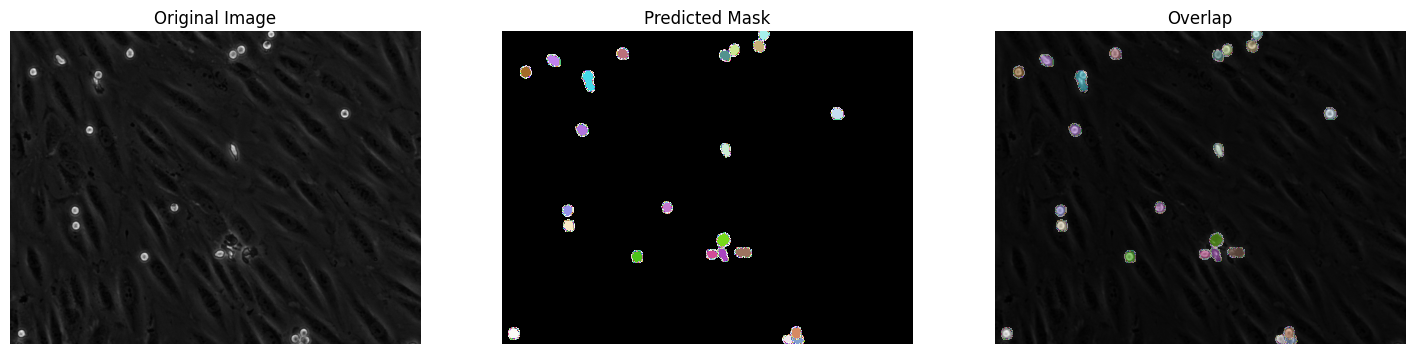

/content/test/frame21_3.png


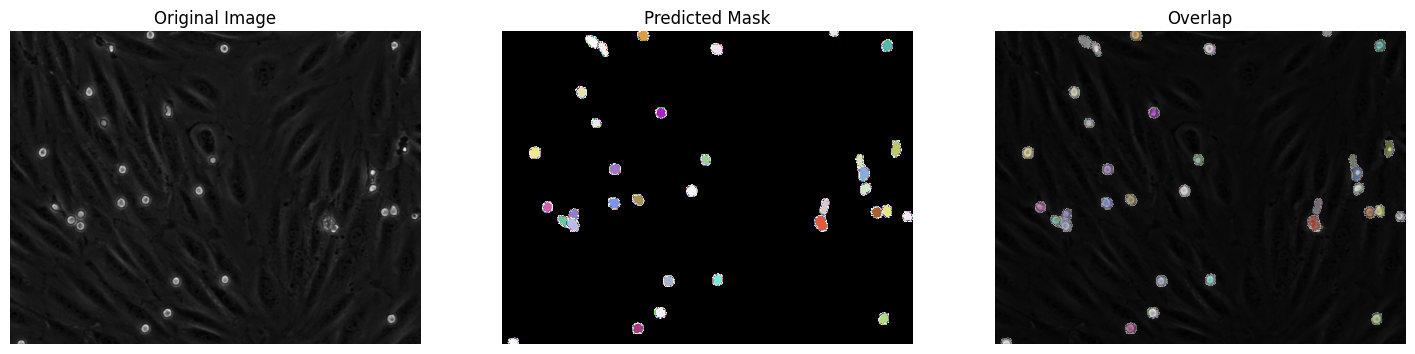

/content/test/frame21_4.png


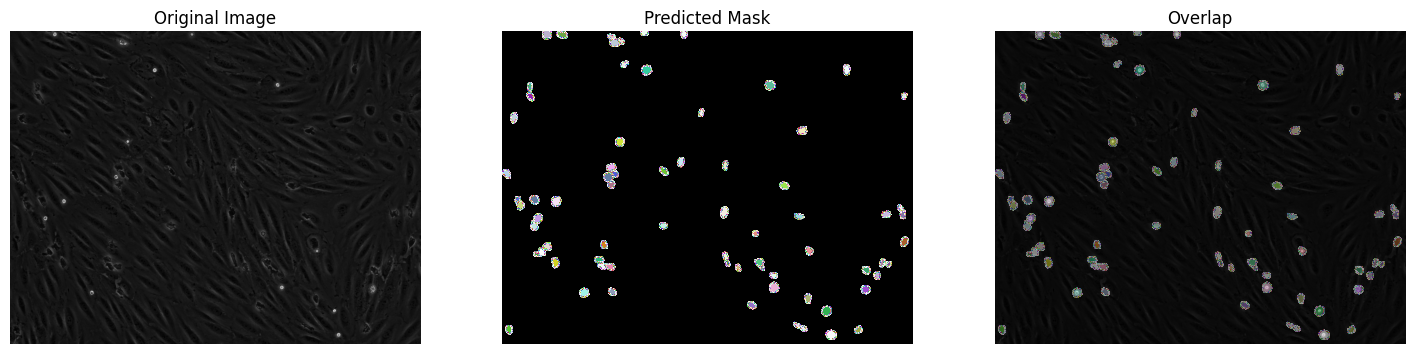

/content/test/frame50.png


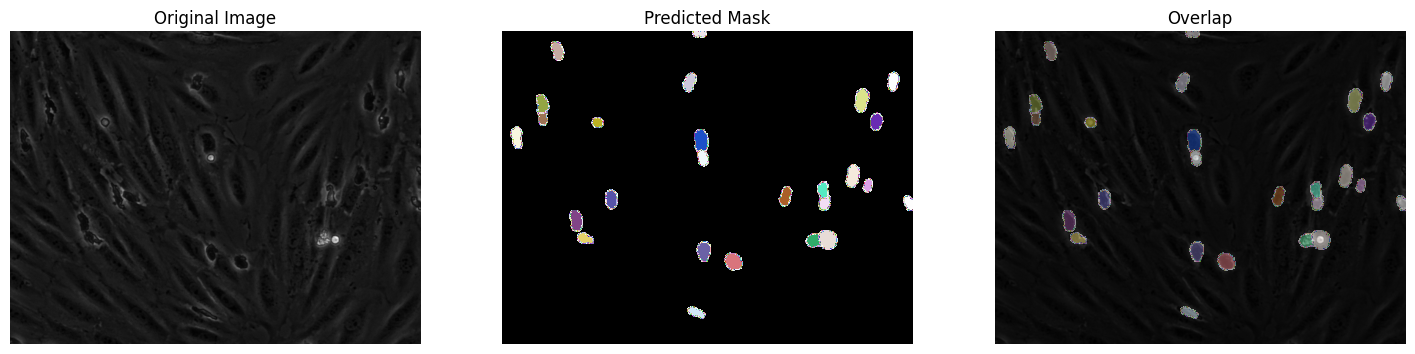

/content/test/frame66_4.png
Saved at:/content/stardist_model/Prediction


In [16]:
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
from skimage import io
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from stardist import random_label_cmap
import tensorflow as tf


Source_QC_folder = "/content/test"  #@param{type:"string"}

save_folder = os.path.join(base_path, QC_model_name, "Prediction")

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

Source_QC_folder_tif = os.path.join(Source_QC_folder, "[!\\.]*")
Z = sorted(glob(Source_QC_folder_tif))
file_paths = Z.copy()
Z = list(map(imread, Z)) if Z[0].split('.')[-1] == 'tif' else [io.imread(str(file_path)) for file_path in Z]
n_channel = 1 if Z[0].ndim == 2 else Z[0].shape[-1]

print('Number of test dataset found in the folder:', len(Z))

model = StarDist2D(None, name='nm', basedir=base_path)
axis_norm = (0, 1) if n_channel == 1 else (0, 1, 2)
lbl_cmap = random_label_cmap()

loaded_model = tf.saved_model.load('/content/model')

for i, img in enumerate(Z):
    img_normalized = normalize(img, 1, 99.8, axis=axis_norm)
    labels, _ = model.predict_instances(img_normalized)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(labels, cmap=lbl_cmap)
    ax[1].set_title('Predicted Mask')
    ax[1].axis('off')

    ax[2].imshow(img, cmap='gray')
    ax[2].imshow(labels, cmap=lbl_cmap, alpha=0.5)  # 重叠预测掩码，透明度设置为0.5
    ax[2].set_title('Overlap')
    ax[2].axis('off')

    plt.show()
    print(file_paths[i])
    filename = os.path.basename(file_paths[i])
    imwrite(os.path.join(save_folder, filename), labels)

print(f"Saved at:{save_folder}")
